
# Return probability 
 


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.quantum_info import Statevector
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math
print('Import Successfully')

Import Successfully


In [3]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [48]:
def errori(circuit, position, n):
    epsilon = 0.5                                                      
    extracted = random.uniform(0, 1)
    #position = random.randint(0, n - 1)    #to have random positions for each error

    if (extracted < epsilon):  
        circuit.x(position)   
    else:
        circuit.z(position)
    return circuit

In [2]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case 
    if n == 0:
        return circuit
    n -= 1    

    if n  >=  tmp:   
        errori(circuit, position, n) 
        if n == tmp: 
            circuit.id(position)    
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [5]:
def qft(circuit, n, n_max, case, position):

    qft_rotations(circuit, n, n_max, case, position)

    if case >= n + 1:
        errori(circuit, position, n)
        if case == n + 1:
            circuit.id(position)
        
    swap_registers(circuit, n)    

    if case >= n + 2:
        errori(circuit, position , n)
        if case == n + 2:
            circuit.id(position)
        
    if case >= 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [6]:
def split_circuit_by_id(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('id'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

Main:
- Fixed number of qubits;
- Fixed Number of errors;
- Each error in a random position OR all in the same random position.

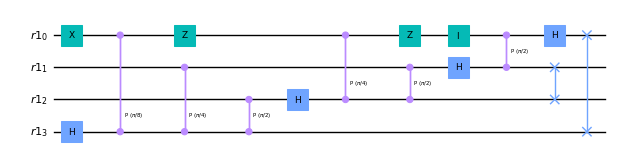

In [60]:
n = 4
case = 3
position = random.randint(0, n - 1)   #all the errors in the same random position

amplitudes = np.empty(2**n)
summa = 0
x = []
plot = []
control = QuantumRegister(n, 'r1')
circuit = QuantumCircuit(control)
qft(circuit, n, n, case, position)  
        
circuit.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

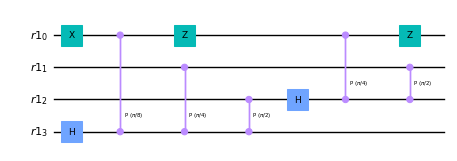

In [61]:
for subcircuit in (split_circuit_by_id(circuit)):
    circuit_left = subcircuit
circuit_left.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

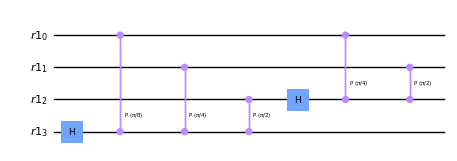

In [62]:
remove = []
circuit_right = QuantumCircuit(control)
circuit_right.data = circuit_left.data
circuit_right.data = list(circuit_right.data)
for i in range(len(circuit_right.data)):
    if circuit_right.data[i].operation.name == 'x' or circuit_right.data[i].operation.name == 'z':
        remove.append(i)

for elem in sorted(remove, reverse = True):
    del circuit_right.data[elem]

circuit_right.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

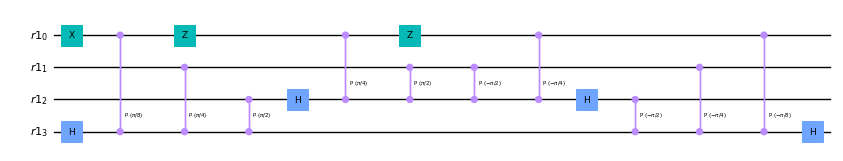

In [63]:
from qiskit.tools.visualization import circuit_drawer

circuit_right = circuit_right.inverse()
merge = circuit_left.compose(circuit_right)

circuit_drawer(merge, output='latex_source',filename = 'QFT_return_prob_multiple.tex', style={'backgroundcolor': '#EEEEEE'})
merge.draw('mpl', fold = -1 , plot_barriers = False, scale = 0.5)

In [28]:
amplitudes = np.empty(2**n)

backend = Aer.get_backend('unitary_simulator')
job = execute(merge, backend, shots = 8192)
result = job.result()
UeU = result.get_unitary(merge,3)
print(array_to_latex(UeU))

for iii in range(2**n):   

    label = bin(iii).lstrip('-0b').zfill(n)
    if case == 0:
        x.append(label)

    state = Statevector.from_label(label)
    amplitudes[iii] = (state.evolve(UeU)[label]**2).real
    state = 0

#print(amplitudes)
array_to_latex(UeU)

<IPython.core.display.Latex object>


<IPython.core.display.Latex object>

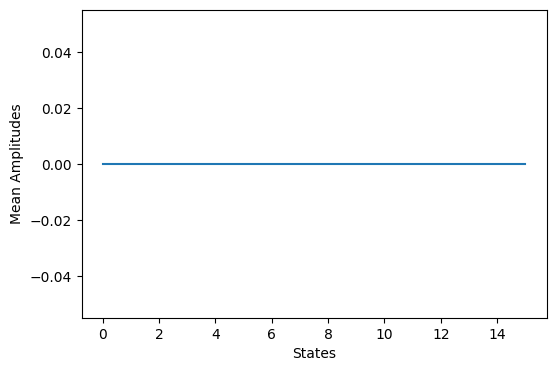

In [32]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 4))
plt.xlabel('States')
plt.ylabel('Mean Amplitudes')
plt.plot(amplitudes)